In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
p = 97  # prime number
train_frac = 0.5  # training fraction
d_model = 128  # model dimension
n_layers = 2  # number of Transformer layers
n_heads = 4  # number of attention heads
batch_size = 512
lr = 0.001
weight_decay = 1  # AdamW weight decay
max_steps = 400

In [3]:
def generate_dataset(p, train_frac):
    pairs = [(a, b, (a+b) % p) for a in range(p) for b in range(p)] # x ◦ y 
    np.random.shuffle(pairs)
    split = int(len(pairs) * train_frac)
    train_data, val_data = pairs[:split], pairs[split:]
    return train_data, val_data

vocab = {'<a>': 0, '<b>': 1, '<op>': 2, '=': 3, **{f'<{i}>': i+4 for i in range(p)}}
vocab_size = len(vocab)

In [4]:
def encode(a, b, c):
    ## input form：<a><op><b>=<c>
    return [
        vocab[f'<{a}>'], vocab['<op>'], vocab[f'<{b}>'], vocab['='], vocab[f'<{c}>']
    ]

## generate the dataset
train_data, val_data = generate_dataset(p, train_frac)
train_sequences = [encode(a, b, c) for a, b, c in train_data]
val_sequences = [encode(a, b, c) for a, b, c in val_data]

## transform into the PyTorch Dataset
def to_tensor(sequences):
    inputs = torch.tensor([seq[:-1] for seq in sequences], dtype=torch.long) # take first (n-1) elements from each sequence
    targets = torch.tensor([seq[-1] for seq in sequences], dtype=torch.long) # take the last element from each sequence
    return TensorDataset(inputs, targets)

train_dataset = to_tensor(train_sequences)
val_dataset = to_tensor(val_sequences)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [5]:
## define a Transformer Model
class GrokkingTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.noise_std = 0.01

        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Parameter(torch.randn(4, d_model))  # the input length 4
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model*4,
            batch_first=True )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(d_model, vocab_size)
        
    def forward(self, x):
        x = self.embed(x) + self.pos_embed  # token embedding plus positional encoding
        
        if self.training:  # add noise in training step
            x = x + torch.randn_like(x) * self.noise_std
            
        mask = torch.triu(torch.ones(4, 4), diagonal=1).bool() 
        x = self.transformer(x, mask=mask) # transformer encoder
        x = x.mean(dim=1) # mean pooling
        return self.fc(x) # classification output

In [7]:
model = GrokkingTransformer()
optimizer = optim.AdamW(model.parameters(), lr=lr,betas=[0.9, 0.98], weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

## training loop (monitoring training/validation accuracy)
train_accs, val_accs = [], []

for step in range(max_steps):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
    
    ## evaluate every N steps
    if step % 10 == 0:
        model.eval()
        # train accuracy
        with torch.no_grad():
            logits = model(train_dataset.tensors[0])
            train_acc = (logits.argmax(dim=1) == train_dataset.tensors[1]).float().mean().item()
        # validation accuracy
        val_acc = 0
        for inputs, targets in val_loader:
            logits = model(inputs)
            val_acc += (logits.argmax(dim=1) == targets).float().mean().item()
        val_acc /= len(val_loader)
        
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Step {step:6d} | Train Accuracy: {train_acc*100:.2f}% | Val Accuracy: {val_acc*100:.2f}%")

Step      0 | Train Accuracy: 1.08% | Val Accuracy: 0.74%
Step     10 | Train Accuracy: 3.47% | Val Accuracy: 0.08%
Step     20 | Train Accuracy: 5.08% | Val Accuracy: 0.00%
Step     30 | Train Accuracy: 7.82% | Val Accuracy: 0.00%
Step     40 | Train Accuracy: 10.99% | Val Accuracy: 0.04%
Step     50 | Train Accuracy: 16.20% | Val Accuracy: 0.00%
Step     60 | Train Accuracy: 20.77% | Val Accuracy: 0.02%
Step     70 | Train Accuracy: 23.45% | Val Accuracy: 0.02%
Step     80 | Train Accuracy: 28.95% | Val Accuracy: 0.06%
Step     90 | Train Accuracy: 43.22% | Val Accuracy: 0.36%
Step    100 | Train Accuracy: 52.98% | Val Accuracy: 1.05%
Step    110 | Train Accuracy: 71.60% | Val Accuracy: 3.09%
Step    120 | Train Accuracy: 83.48% | Val Accuracy: 5.84%
Step    130 | Train Accuracy: 87.07% | Val Accuracy: 9.67%
Step    140 | Train Accuracy: 92.56% | Val Accuracy: 15.76%
Step    150 | Train Accuracy: 95.15% | Val Accuracy: 22.79%
Step    160 | Train Accuracy: 98.11% | Val Accuracy: 36.71

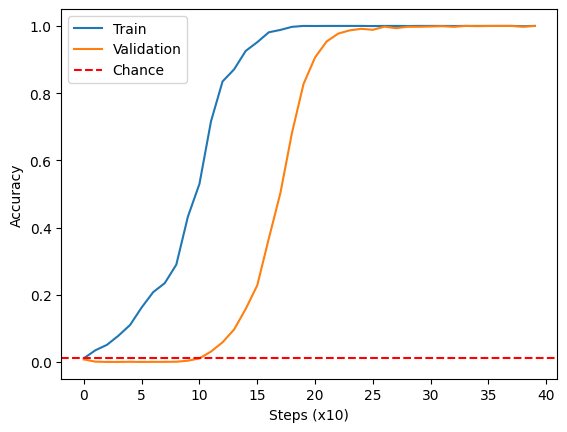

In [8]:
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.axhline(y=1/p, color='r', linestyle='--', label='Chance')
plt.xlabel('Steps (x10)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()